In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import time

In [2]:
#定義device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# 注意需要將每個電池的 mat 檔放在此文記資料夾中
def load_data(batteries):
    # 初始化計數器和數據集列表
    counter = 0
    dataset = []
    capacity_data = []
    
    # 迭代處理每個電池
    for battery in batteries:
        # 載入 '.mat' 檔案中的數據
        mat = loadmat('battery_data/' + battery + '.mat')
        
        # 輸出總共的數據筆數
        print(f'Total data in dataset for {battery}: ', len(mat[battery][0, 0]['cycle'][0]))
        
        # 迭代處理每一個週期的數據
        for i in range(len(mat[battery][0, 0]['cycle'][0])):
            row = mat[battery][0, 0]['cycle'][0, i]
            
            # 只處理 'discharge' 類型的數據
            if row['type'][0] == 'discharge':
                ambient_temperature = row['ambient_temperature'][0][0]
                
                # 將時間信息轉換為 datetime 對象
                date_time = datetime.datetime(int(row['time'][0][0]),
                                               int(row['time'][0][1]),
                                               int(row['time'][0][2]),
                                               int(row['time'][0][3]),
                                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
                
                data = row['data']
                capacity = data[0][0]['Capacity'][0][0]
                
                # 迭代處理每個時間步的數據
                for j in range(len( data[0][0]['Temperature_measured'][0])):
                    temperature_measured = data[0][0]['Temperature_measured'][0][j]
                    current_load = data[0][0]['Current_load'][0][j]
                    voltage_load = data[0][0]['Voltage_load'][0][j]
                    time = data[0][0]['Time'][0][j]
                    
                    # 將數據添加到數據集中
                    dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                    temperature_measured, current_load,
                                    voltage_load, time])
                
                # 將電池容量數據添加到容量數據集中
                capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
                counter = counter + 1
                
    # 輸出第一筆數據
    print(dataset[0])
    
    # 返回數據集和電池容量數據集
    return [pd.DataFrame(data=dataset,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity'])]

# 使用 ['B0005', 'B0006', 'B0007', 'B0018'] 作為電池編號載入數據
dataset, capacity = load_data(['B0029', 'B0030', 'B0031', 'B0032'])

# 設置 pandas 的顯示選項
pd.set_option('display.max_columns', 10)

# 輸出數據集的前幾行
print(dataset.head())

# 描述性統計
dataset.describe()

Total data in dataset for B0029:  97
Total data in dataset for B0030:  97
Total data in dataset for B0031:  97
Total data in dataset for B0032:  97
[1, 43, datetime.datetime(2009, 4, 7, 16, 31, 1), 1.697507332205763, 43.41517780938604, 0.0004, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  \
0      1                   43 2009-04-07 16:31:01  1.697507   
1      1                   43 2009-04-07 16:31:01  1.697507   
2      1                   43 2009-04-07 16:31:01  1.697507   
3      1                   43 2009-04-07 16:31:01  1.697507   
4      1                   43 2009-04-07 16:31:01  1.697507   

   temperature_measured  current_load  voltage_load    time  
0             43.415178        0.0004         0.000   0.000  
1             43.406266        0.0006         4.138   9.359  
2             43.443006        3.9950         1.854  19.453  
3             43.558959        3.9950         1.820  28.781  
4             43.721550        3.9950         1.806  38.1

,cycle,ambient_temperature,capacity,temperature_measured,current_load,voltage_load,time
count,25404.000000,25404.0,25404.000000,25404.000000,25404.000000,25404.000000,25404.000000
mean,79.647300,43.0,1.725416,53.770311,3.867027,1.398776,808.943935
std,46.185903,0.0,0.069849,4.405452,0.712818,0.402015,470.911440
min,1.000000,43.0,1.562780,42.830036,0.000400,0.000000,0.000000
25%,40.750000,43.0,1.675003,50.677961,3.995000,1.277000,401.359000
50%,80.500000,43.0,1.725254,54.255904,3.997000,1.427000,808.438000
75%,120.250000,43.0,1.776540,57.100951,4.001000,1.573000,1215.109000
max,160.000000,43.0,1.894032,63.024216,4.001000,4.223000,1723.281000


In [4]:
# 選取需要的特徵（'cycle', 'datetime', 'capacity'）
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]

# 獲取初始電池容量（第一個循環的容量）
C = dis_ele['capacity'][0]

# 迭代處理每一行數據
for i in range(len(dis_ele)):
    # 計算電池狀態健康度（SoH），將其添加到 DataFrame 中
    dis_ele['SoH'] = (dis_ele['capacity']) / C
    
# 從數據集中獲取初始電池容量
C = dataset['capacity'][0]

# 計算狀態健康度（SoH）並轉換為 PyTorch 张量
soh = torch.tensor(dataset['capacity'].values / C, dtype=torch.float32).view(-1, 1)
soh = soh.unsqueeze(1)  # 添加一個額外的維度，以便與 PyTorch 兼容


# 選取需要的特徵
attribs = ['capacity', 'temperature_measured','current_load', 'voltage_load', 'time']

# 提取所選屬性的特徵
train_dataset = torch.tensor(dataset[attribs].values, dtype=torch.float32)

# 正規化數據
min_vals = torch.min(train_dataset, dim=0).values
max_vals = torch.max(train_dataset, dim=0).values
train_dataset = (train_dataset - min_vals) / (max_vals - min_vals)
train_dataset = train_dataset.unsqueeze(1)
# 假設 train_dataset 是一個時間序列，可能需要根據特定需求進行形狀調整
# 根據實際需求，可能需要根據特定的形狀需求來重新塑造 train_dataset

In [5]:
# define LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNN_LSTM, self).__init__()

        # 第一層 CNN
        self.cnn = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=64, kernel_size=1),
        nn.ReLU(),
        nn.Flatten()
        )

        # 第一層 LSTM
        self.lstm1 = nn.LSTMCell(64*5, hidden_size)  # 輸入通道數為 32*5
        self.dropout1 = nn.Dropout(0.07)
        # 第二層 LSTM
        self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.09)
        # 第三層 LSTM
        self.lstm3 = nn.LSTMCell(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(0.09)
        # 第四層 LSTM
        self.lstm4 = nn.LSTMCell(hidden_size, hidden_size)
        self.dropout4 = nn.Dropout(0.12)

        # 最後的全連接層
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 第一層 CNN
        cnn_output = self.cnn(x)

        # 第一層 LSTM
        h_t, c_t = self.lstm1(cnn_output)
        out = self.dropout1(h_t)
        # 第二層 LSTM
        h_t, c_t = self.lstm2(out)
        out = self.dropout2(h_t)
        # 第三層 LSTM
        h_t, c_t = self.lstm3(out)
        out = self.dropout3(h_t)
        # 第四層 LSTM
        h_t, c_t = self.lstm4(out)
        out = self.dropout4(h_t)

        # 最後的全連接層，取最後一個時間步的輸出
        out = self.fc(out)

        return out

In [6]:
# Define the PyTorch model, loss function, and optimizer
input_size = len(attribs)
print(attribs)
hidden_size = 224
output_size = 1
regress = CNN_LSTM(input_size,hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(regress.parameters(), lr=0.01)

['capacity', 'temperature_measured', 'current_load', 'voltage_load', 'time']


In [7]:
# Convert the dataset and labels to PyTorch DataLoader
train_data = TensorDataset(train_dataset, soh)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [8]:
# Training the model
num_epochs = 10
start_time=time.time()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels =  inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = regress(inputs)
        loss = criterion(outputs, labels.squeeze(1))
        loss.backward()
        optimizer.step()
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
end_time=time.time()
print("training time:",end_time-start_time)
regress = regress.to('cpu')

training time: 76.78713750839233


In [9]:
# Print model summary
# Example of using the trained model for prediction'
# Assuming 'test_input' is a tensor of shape (batch_size, input_size)
for inputs, labels in train_loader:
    predicted_soh = regress(inputs)
    predicted_soh = predicted_soh.detach().numpy()

    # You can use 'predicted_soh' for further analysis or visualization
#    print(predicted_soh)
#    print(labels)
model_params = regress.state_dict()

In [10]:
def load_data1(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Temperature_measured'][0])):
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity','temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [11]:
# 載入驗證數據集
dataset_val, capacity_val = load_data1('B0030')

# 選擇指定特徵
attrib = ['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]

# 計算初始容量並計算狀態健康度
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH'] = (dis_ele['capacity']) / C

# 印出數據集的前五行
print(dataset_val.head(5))
print(dis_ele.head(5))

# 選擇其他特徵
attrib = ['capacity', 'temperature_measured', 'current_load', 'voltage_load', 'time']

Total data in dataset:  97
[1, 43, datetime.datetime(2009, 4, 7, 16, 31, 1), 1.6560706096175404, 43.15149833518289, 0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  \
0      1                   43 2009-04-07 16:31:01  1.656071   
1      1                   43 2009-04-07 16:31:01  1.656071   
2      1                   43 2009-04-07 16:31:01  1.656071   
3      1                   43 2009-04-07 16:31:01  1.656071   
4      1                   43 2009-04-07 16:31:01  1.656071   

   temperature_measured  current_load  voltage_load    time  
0             43.151498        0.0006         0.000   0.000  
1             43.152386        0.0006         4.137   9.359  
2             43.178662        4.0010         1.894  19.453  
3             43.296200        4.0010         1.882  28.781  
4             43.451123        4.0010         1.866  38.156  
   cycle            datetime  capacity       SoH
0      1 2009-04-07 16:31:01  1.656071  1.000000
1      2 2009-04-

In [12]:
# Convert DataFrame to PyTorch tensor
dataset_val_tensor = torch.tensor(dataset_val[attrib].values, dtype=torch.float32)

# Calculate mean and standard deviation
mean = torch.mean(dataset_val_tensor, dim=0)
std = torch.std(dataset_val_tensor, dim=0)

# Normalize the entire dataset 

min_vals_tensor= torch.min(dataset_val_tensor, dim=0).values
max_vals_tensor = torch.max(dataset_val_tensor, dim=0).values
# 使用 min 和 max 值進行標準化
normalized_dataset_val = (dataset_val_tensor - min_vals_tensor) / (max_vals_tensor - min_vals_tensor)

# 或者使用平均值和標準差進行標準化
#normalized_dataset_val = (dataset_val_tensor - mean) / std
normalized_dataset_val = normalized_dataset_val.unsqueeze(1)
# Make predictions
soh_pred = regress(normalized_dataset_val)

print(soh_pred.size())

torch.Size([6351, 1])


In [13]:
# Assuming 'dataset_val' has a 'cycle' column
new_soh = pd.DataFrame({'cycle': dataset_val['cycle'], 'SoH': dataset_val['capacity'] / C, 'NewSoH': soh_pred.detach().numpy().flatten()})
new_soh = new_soh.groupby(['cycle']).mean().reset_index()

print(new_soh.head(10))

   cycle       SoH    NewSoH
0      1  1.000000  1.003524
1      2  1.075772  1.109644
2      3  1.063946  1.096196
3      4  1.057778  1.087621
4      5  1.049574  1.076220
5      6  1.057126  1.086533
6      7  1.056178  1.085421
7      8  1.041776  1.064328
8      9  1.033327  1.051935
9     10  1.025948  1.040899


Root Mean Square Error:  0.06454492750244534


C:\Users\E1025\AppData\Local\Temp\ipykernel_9152\625284127.py:5: UserWarning: Using a target size (torch.Size([6351, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rms = torch.sqrt(F.mse_loss(torch.tensor(new_soh['SoH'].values), torch.tensor(predicted_soh_np)))


Text(0.5, 1.0, 'Discharge B0030')

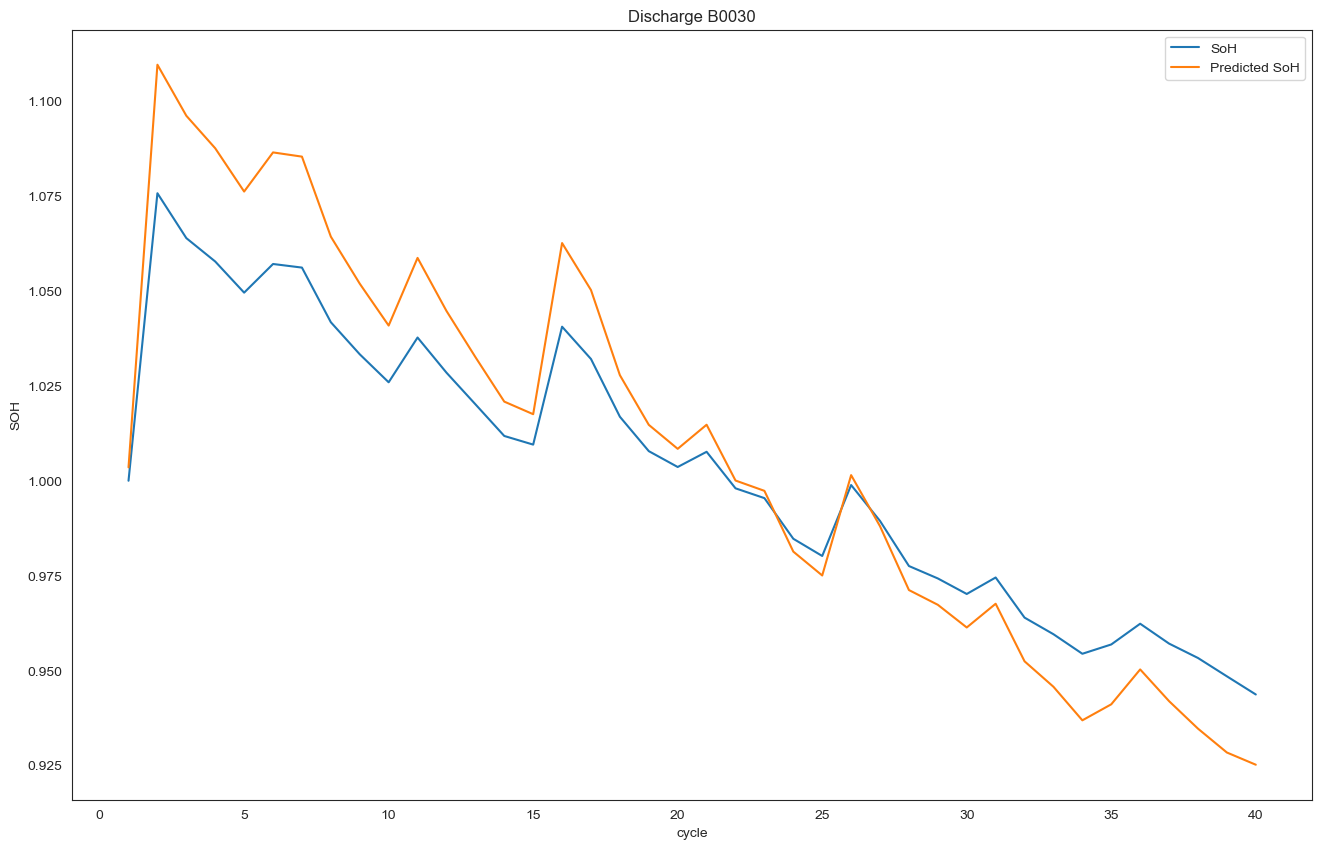

In [14]:
# Calculate RMSE
predicted_soh_np = soh_pred.detach().numpy()

# 使用 PyTorch 提供的均方差函數計算 RMSE
rms = torch.sqrt(F.mse_loss(torch.tensor(new_soh['SoH'].values), torch.tensor(predicted_soh_np)))
print('Root Mean Square Error: ', rms.item())


plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0030')